# MLP and CNN for CIFAR10

**Acknowledgment:**
Soroush Arabshahi sa3617@columbia.edu

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, accuracy_score

%config Completer.use_jedi = False

In [2]:
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

torch.manual_seed(4460)# you don't have to set random seed beyond this block
np.random.seed(4460)

GPU available: True


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100
train_valid_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
trainset, validset = random_split(train_valid_set, [40000, 10000])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


(a) The image has a shape 32 x 32
(b) The image has 3 channels.
(c) The training set has 400 batches, the testing set has 100 batches, the validation set has 100 batches.


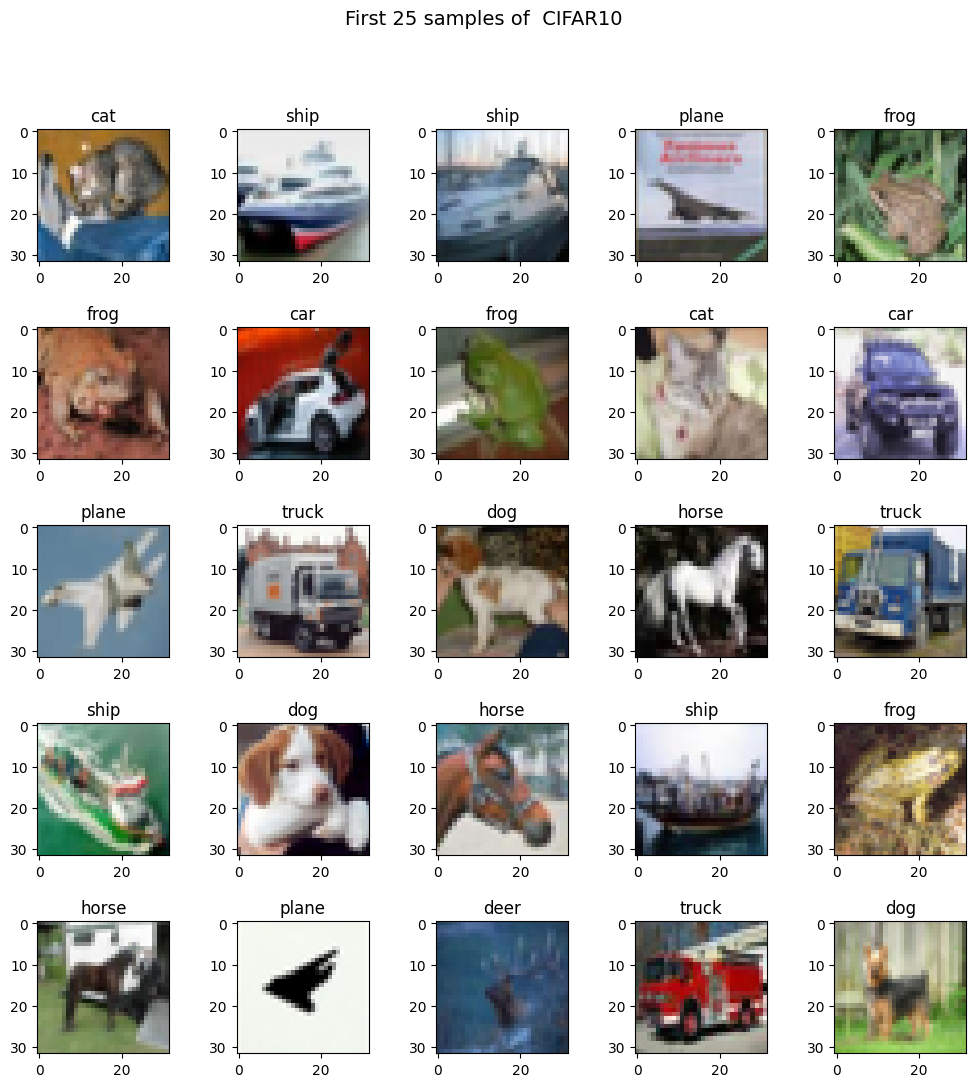

In [4]:
# Plotting the sample
plt.figure(figsize=(12,12))
plt.suptitle("First 25 samples of  CIFAR10 ", fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(25):
    plt.subplot(5,5,i+1)
    im, lab = testset[i]
    im = im.numpy()
    im = (im* 0.5 + 0.5) * 255
    im = im.astype(np.uint8) # arrays representing images
    im = np.transpose(im, (1, 2, 0)) # transpose to H W C
    plt.title(classes[lab])
    plt.imshow(im)




In [5]:
class MLPModel(nn.Module):
    '''Reshape -> FC -> Sigmoid -> FC -> Sigmoid -> FC -> SoftMax -> Cross-Entropy'''
    def __init__(self):
        '''Define model modules.'''
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32 , 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = x.view(-1, 3 * 32 * 32)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

our_MLP = MLPModel()

# If GPU available, move the model to GPU.
if cuda:
    our_MLP.cuda()

print(our_MLP)


MLPModel(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
optim = torch.optim.Adam(our_MLP.parameters(), lr=0.001)

In [7]:
epochs = 25
loss_function = nn.CrossEntropyLoss()
train_epoch_loss = []
valid_epoch_loss = []

for epoch in range(epochs):
    # Train the model
    train_loss = []
    our_MLP.train()
    for batch_index, (x, y) in enumerate(trainloader):

        y_pred = our_MLP(x.cuda())  # forward pass
        loss =  loss_function(y_pred, y.cuda())  # compute loss with respect to actual labels (y)
        train_loss.append(loss.item())
        optim.zero_grad()  # set gradient to zero
        loss.backward()  # backpropagate loss
        optim.step()  # optimize

    train_epoch_loss.append(np.mean(train_loss))  # Average loss per batch

    # Validation of the model
    our_MLP.eval()
    valid_loss = []
    for batch_index, (x_val, y_val) in enumerate(validloader):

        y_pred_val = our_MLP(x_val.cuda())  # forward pass
        loss = loss_function(y_pred_val, y_val.cuda())  # compute validation loss
        valid_loss.append(loss.cpu().data.item())
    valid_epoch_loss.append(np.mean(valid_loss))   # Average loss per batch


    print('Epoch', epoch, '. training loss:', train_epoch_loss[epoch], ', validation loss:', valid_epoch_loss[epoch])

    # Save model
    if not os.path.exists('./mlp'):
        os.makedirs('./mlp')
    torch.save(our_MLP.state_dict(), './mlp/mlp_model_epoch_{}.pt'.format(epoch+1))

Epoch 0 . training loss: 1.9094975262880325 , validation loss: 1.7729340422153472
Epoch 1 . training loss: 1.7082356321811676 , validation loss: 1.674110392332077
Epoch 2 . training loss: 1.614389481842518 , validation loss: 1.6237071299552917
Epoch 3 . training loss: 1.55087210804224 , validation loss: 1.5833452033996582
Epoch 4 . training loss: 1.4957773724198342 , validation loss: 1.5722269225120544
Epoch 5 . training loss: 1.4490605235099792 , validation loss: 1.5458845257759095
Epoch 6 . training loss: 1.4061318230628967 , validation loss: 1.5461916661262511
Epoch 7 . training loss: 1.3626898977160453 , validation loss: 1.5292763435840606
Epoch 8 . training loss: 1.32765359044075 , validation loss: 1.5288625597953795
Epoch 9 . training loss: 1.287630665898323 , validation loss: 1.5263302183151246
Epoch 10 . training loss: 1.252482680976391 , validation loss: 1.5234297609329224
Epoch 11 . training loss: 1.217950734347105 , validation loss: 1.5277934539318085
Epoch 12 . training los

In [8]:
best_epoch = np.argmin(valid_epoch_loss)
print('The best epoch is: ', best_epoch)

The best epoch is:  10


Text(0.5, 1.0, 'Learning curves')

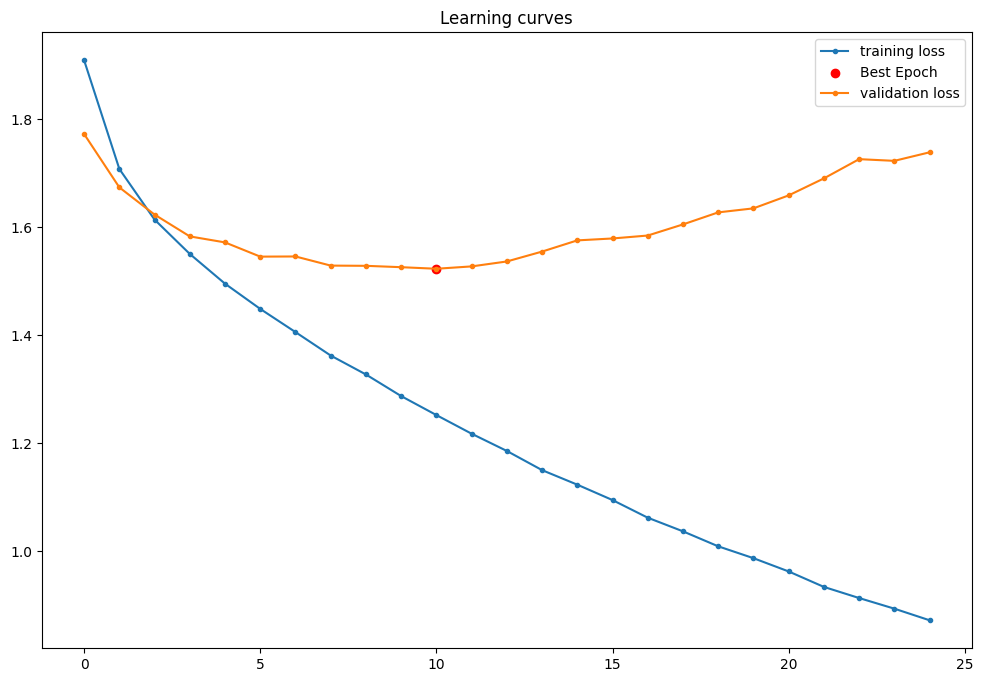

In [13]:
plt.figure(figsize = (12, 8))
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
plt.scatter(best_epoch, valid_epoch_loss[best_epoch], c='red', label='Best Epoch')
plt.plot(valid_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');
plt.title('Learning curves')

In [23]:
state_dict = torch.load('mlp_model_epoch_10.pt')
print(state_dict.keys())
our_MLP.load_state_dict(state_dict)

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


<All keys matched successfully>

In [34]:
def predict_with_pytorch(model, input_data):
    model.eval()
    label_predicted_all = []

    label_predicted_one_hot = model(input_data)
    label_predicted_probability, label_predicted_index = torch.max(label_predicted_one_hot.data, 1)

    for current_prediction in label_predicted_index:
        label_predicted_all.append(current_prediction.detach().cpu().numpy().item())

    return label_predicted_all

# Accuracy

accuracy_ov = []
CM = np.zeros((10, 10), dtype=int)

for batch_index, (x_test, y_test) in enumerate(testloader):

    y_test_pred = predict_with_pytorch(our_MLP, x_test.cuda())
    accuracy_ov.append(accuracy_score(y_test, y_test_pred))
    CM = CM + confusion_matrix(y_test, y_test_pred)

print("The overall accuracy is", np.mean(accuracy_ov) * 100, "%")

The overall accuracy is 46.699999999999996 %


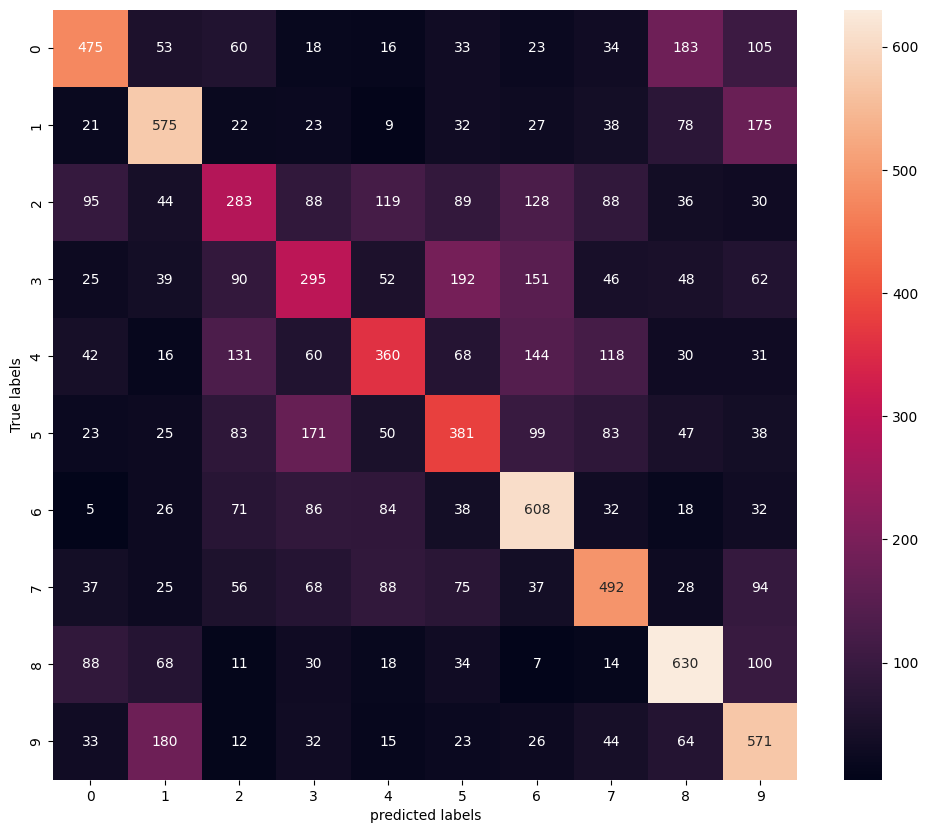

In [35]:
plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');

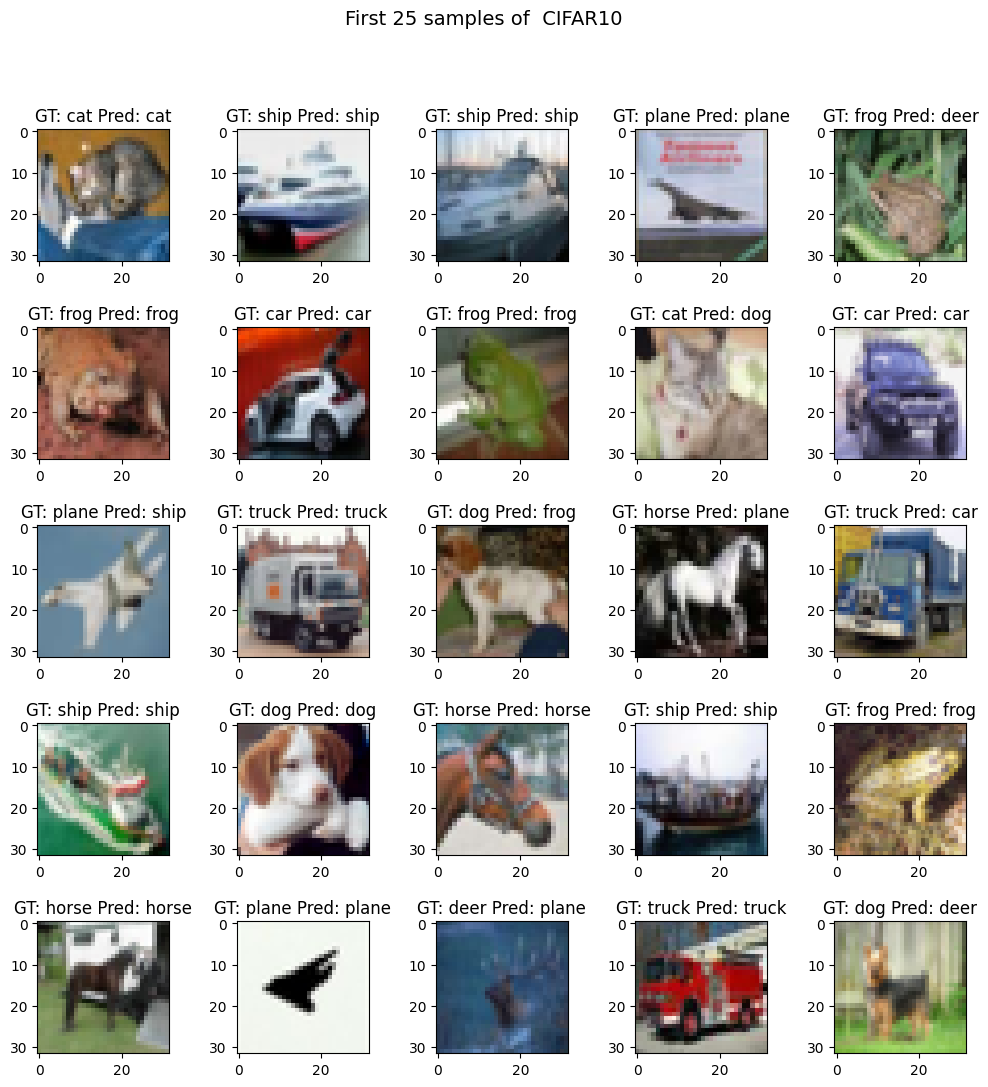

In [42]:
plt.figure(figsize=(12,12))
plt.suptitle("First 25 samples of  CIFAR10 ", fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(25):
    plt.subplot(5,5,i+1)
    im, lab = testset[i]
    im = im.numpy()
    im = (im* 0.5 + 0.5) * 255
    im = im.astype(np.uint8) # arrays representing images
    im = np.transpose(im, (1, 2, 0)) # transpose to H W C
    plt.title("GT: " + classes[testset[i][1]] + " Pred: " + classes[predict_with_pytorch(our_MLP, testset[i][0].cuda())[0]])


    plt.imshow(im)



The MLP performance is very poor, even below 'chance' (50%). A lot of the images are not labeled properly. A simple MLP is not sufficient to predict images labels such as CIFAR10. We can see that the minimum validation loss is on the 10th epoch, which is very early on. This shows that the model is overfitting on the training data.

In [4]:
class LeNet5Model(nn.Module):
    '''ConvNet -> ReLU -> Max_Pool -> ConvNet -> ReLU -> Max_Pool -> Reshape -> FC -> Sigmoid -> FC -> Sigmoid -> FC -> SoftMax -> Cross-Entropy'''
    def __init__(self):
        '''Define model modules.'''
        super(LeNet5Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) # 3 input channels (RGB)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 16)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

our_LeNet = LeNet5Model()

# If GPU available, move the model to GPU.
if cuda:
    our_LeNet.cuda()

print(our_LeNet)


LeNet5Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
optim = Adam(our_LeNet.parameters(), lr = 0.001)

In [8]:
epochs = 25
loss_function = nn.CrossEntropyLoss()
train_epoch_loss = []
valid_epoch_loss = []

for epoch in range(epochs):
    # Train the model
    train_loss = []
    our_LeNet.train()
    for batch_index, (x, y) in enumerate(trainloader):

        y_pred = our_LeNet(x.cuda())  # forward pass
        loss =  loss_function(y_pred, y.cuda())  # compute loss with respect to actual labels (y)
        train_loss.append(loss.item())
        optim.zero_grad()  # set gradient to zero
        loss.backward()  # backpropagate loss
        optim.step()  # optimize

    train_epoch_loss.append(np.mean(train_loss))  # Average loss per batch

    # Validation of the model
    our_LeNet.eval()
    valid_loss = []
    for batch_index, (x_val, y_val) in enumerate(validloader):

        y_pred_val = our_LeNet(x_val.cuda())  # forward pass
        loss = loss_function(y_pred_val, y_val.cuda())  # compute validation loss
        valid_loss.append(loss.cpu().data.item())
    valid_epoch_loss.append(np.mean(valid_loss))   # Average loss per batch


    print('Epoch', epoch, '. training loss:', train_epoch_loss[epoch], ', validation loss:', valid_epoch_loss[epoch])

    # Save model
    if not os.path.exists('./cnn'):
        os.makedirs('./cnn')
    torch.save(our_LeNet.state_dict(), './cnn/cnn_model_epoch_{}.pt'.format(epoch+1))

Epoch 0 . training loss: 1.9002823695540427 , validation loss: 1.6437314188480376
Epoch 1 . training loss: 1.5374237245321274 , validation loss: 1.4592429268360139
Epoch 2 . training loss: 1.4032216948270797 , validation loss: 1.3965818583965302
Epoch 3 . training loss: 1.3264501184225082 , validation loss: 1.312028101682663
Epoch 4 . training loss: 1.2623441998660565 , validation loss: 1.261349819302559
Epoch 5 . training loss: 1.208778488188982 , validation loss: 1.2268095052242278
Epoch 6 . training loss: 1.1605358062684537 , validation loss: 1.2018629324436187
Epoch 7 . training loss: 1.115350865572691 , validation loss: 1.1783863759040833
Epoch 8 . training loss: 1.074108175933361 , validation loss: 1.1576965898275375
Epoch 9 . training loss: 1.0360014469921588 , validation loss: 1.1429424977302551
Epoch 10 . training loss: 1.0020287556946277 , validation loss: 1.1477266639471053
Epoch 11 . training loss: 0.9690193089842797 , validation loss: 1.1180851793289184
Epoch 12 . training

In [9]:
best_epoch = np.argmin(valid_epoch_loss)
print('The best epoch is: ', best_epoch)

The best epoch is:  14


Text(0.5, 1.0, 'Learning curves LeNet')

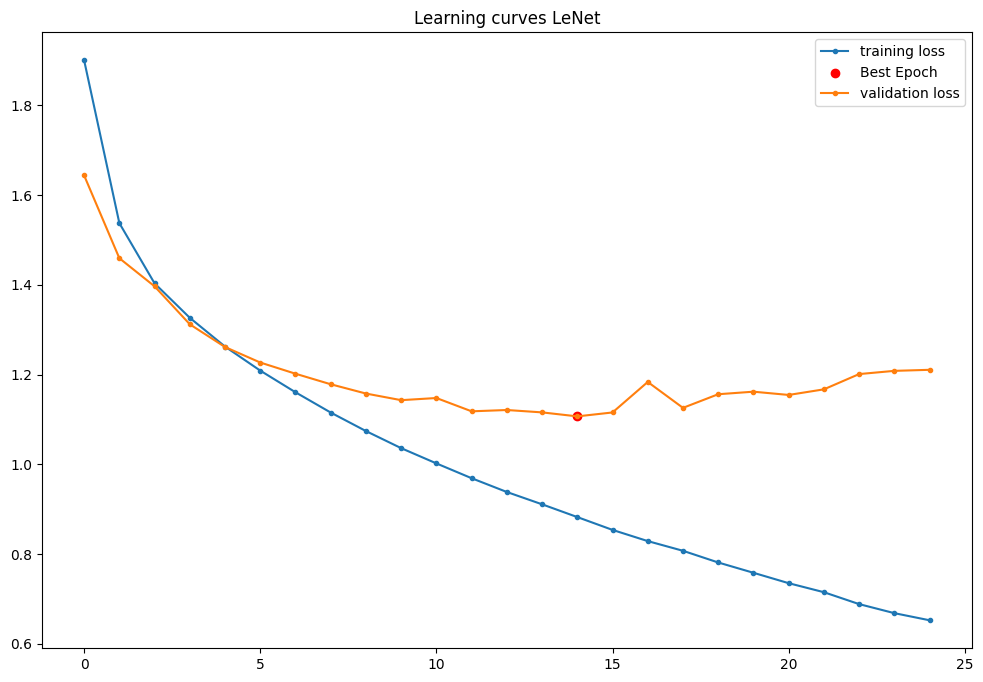

In [10]:
plt.figure(figsize = (12, 8))
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
plt.scatter(best_epoch, valid_epoch_loss[best_epoch], c='red', label='Best Epoch')
plt.plot(valid_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');
plt.title('Learning curves LeNet')

In [14]:
state_dict = torch.load('cnn_model_epoch_14.pt')
print(state_dict.keys())
our_LeNet.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


<All keys matched successfully>

In [15]:
def predict_with_pytorch(model, input_data):
    model.eval()
    label_predicted_all = []

    label_predicted_one_hot = model(input_data)
    label_predicted_probability, label_predicted_index = torch.max(label_predicted_one_hot.data, 1)

    for current_prediction in label_predicted_index:
        label_predicted_all.append(current_prediction.detach().cpu().numpy().item())

    return label_predicted_all


accuracy_ov = []
CM = np.zeros((10, 10), dtype=int)

for batch_index, (x_test, y_test) in enumerate(testloader):

    y_test_pred = predict_with_pytorch(our_LeNet, x_test.cuda())
    accuracy_ov.append(accuracy_score(y_test, y_test_pred))
    CM = CM + confusion_matrix(y_test, y_test_pred)

print("The overall accuracy is", np.mean(accuracy_ov) * 100, "%")

The overall accuracy is 61.559999999999995 %


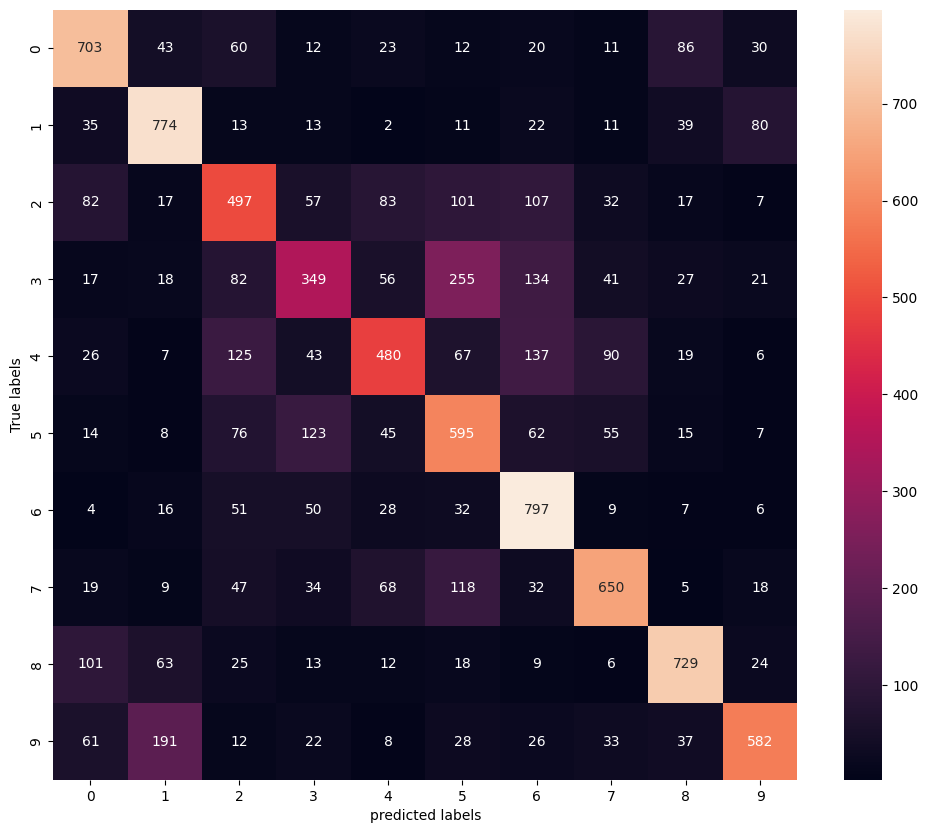

In [16]:
plt.figure(figsize = (12,10))
sns.heatmap(CM, annot = True, annot_kws = {"size": 10}, fmt='d')
plt.ylabel('True labels');
plt.xlabel('predicted labels');

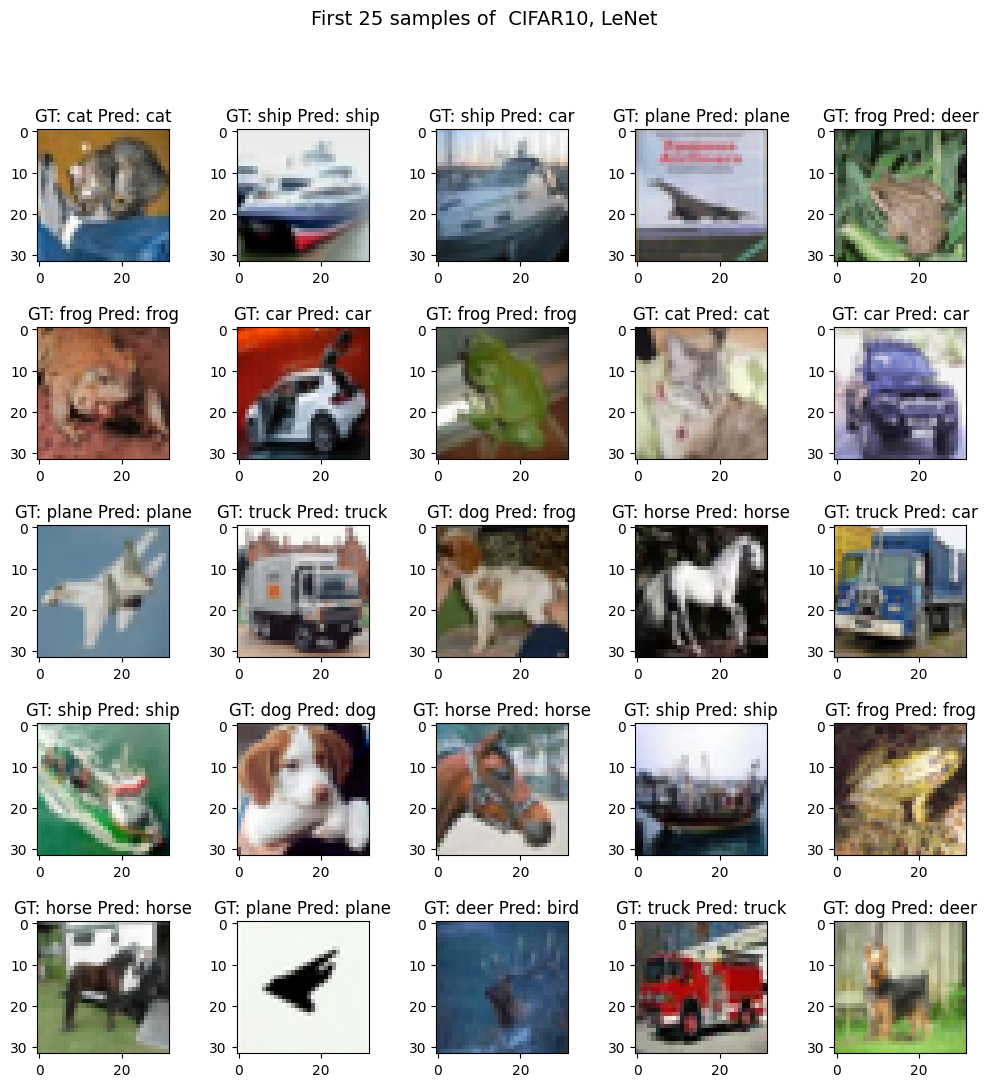

In [18]:
plt.figure(figsize=(12,12))
plt.suptitle("First 25 samples of  CIFAR10, LeNet ", fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(25):
    plt.subplot(5,5,i+1)
    im, lab = testset[i]
    im = im.numpy()
    im = (im* 0.5 + 0.5) * 255
    im = im.astype(np.uint8) # arrays representing images
    im = np.transpose(im, (1, 2, 0)) # transpose to H W C
    plt.title("GT: " + classes[testset[i][1]] + " Pred: " + classes[predict_with_pytorch(our_LeNet, testset[i][0].cuda())[0]])


    plt.imshow(im)



The accuracy of the LeNet model is about 15% higher than the accuracy of the MLP model. The best validation epoch is 14, which is slightly better, but the LeNet is still prone to overfitting. We can also see that the confusion matrix is better for LeNet. However, both models perform poorly.

One of the issues of the LeNet model is overfitting. To prevent it, we can train it on a larger dataset, introduce Dropout, or add a L2 regularization term